In [14]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dash.dependencies import Input, Output, State

In [15]:
# Load data from the Excel file
file_path = 'Investment Data 2020-2024 (1).xlsx'
metadata_df = pd.read_excel(file_path, sheet_name='Company MetaData-2024')
data = pd.read_excel(file_path, sheet_name='2020-2024')

In [16]:
# Remove rows where 'Ticker' is NaN
data = data.dropna(subset=['Ticker'])

# Convert 'Date' and 'Time' columns to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.time
data['Time'] = data['Time'].apply(lambda x: x if pd.notnull(x) else pd.Timestamp('00:00:00').time())

# Combine 'Date' and 'Time' into a single datetime column
data['DateTime'] = data.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)

# Sort the data by 'Name' and 'DateTime'
data_sorted = data.sort_values(by=['Name', 'DateTime'])

# Get the list of unique company names and their tickers
companies = data_sorted['Name'].unique()
tickers = data_sorted['Ticker'].unique()

In [17]:
# Fetch historical data for each ticker
historical_data = {}
ticker_info = []
for ticker in tickers:
    try:
        # Download historical data
        ticker_data = yf.download(ticker, start="2019-01-01", end="2024-12-31")
        ticker_data['50MA'] = ticker_data['Close'].rolling(window=50).mean()
        ticker_data['100MA'] = ticker_data['Close'].rolling(window=100).mean()
        ticker_data['200MA'] = ticker_data['Close'].rolling(window=200).mean()
        
        # Ensure the moving averages are aligned with the historical data
        ticker_data.dropna(inplace=True)  # Remove rows with NaN values
        
        historical_data[ticker] = ticker_data
        
        # Fetch sector and industry information
        ticker_object = yf.Ticker(ticker)
        sector = ticker_object.info.get('sector', 'Unknown')
        industry = ticker_object.info.get('industry', 'Unknown')
        ticker_info.append({
            'Ticker': ticker,
            'Sector': sector,
            'Industry': industry
        })
    except Exception as e:
        print(f"Failed to get data for ticker '{ticker}' reason: {e}")

# Convert ticker_info to a DataFrame
ticker_info_df = pd.DataFrame(ticker_info)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [18]:
# Ensure Ticker column in metadata is consistent with historical_data keys
metadata_df['Ticker Symbol'] = metadata_df['Ticker Symbol'].str.strip()

# Calculate profit/loss percentage for each ticker
profit_loss_info = []
for ticker in tickers:
    try:
        if ticker in metadata_df['Ticker Symbol'].values:
            avg_price_per_share = metadata_df.loc[metadata_df['Ticker Symbol'] == ticker, 'Average Price per Share \n(=Total Purchase Amount / Total Number of Shares)'].values[0]
            if ticker in historical_data and not historical_data[ticker].empty:
                current_price = historical_data[ticker]['Close'].iloc[-1]  # Get the latest closing price
                if avg_price_per_share != 0:
                    profit_loss_percentage = ((current_price - avg_price_per_share) / avg_price_per_share) * 100
                    profit_loss_info.append({
                        'Ticker': ticker,
                        'Profit/Loss Percentage': profit_loss_percentage
                    })
                else:
                    print(f"Average price per share for ticker '{ticker}' is zero, cannot calculate profit/loss.")
            else:
                print(f"No historical data available for ticker '{ticker}'.")
        else:
            print(f"No metadata available for ticker '{ticker}'.")
    except Exception as e:
        print(f"Failed to calculate profit/loss for ticker '{ticker}' reason: {e}")

# Convert profit_loss_info to a DataFrame
profit_loss_df = pd.DataFrame(profit_loss_info)

No historical data available for ticker 'LVGO'.
Average price per share for ticker 'MTB' is zero, cannot calculate profit/loss.
Average price per share for ticker 'ONL' is zero, cannot calculate profit/loss.
No historical data available for ticker 'PBCT'.
No historical data available for ticker 'STOR'.
No historical data available for ticker 'SBNY'.
No historical data available for ticker 'WORK'.


In [19]:
# Convert profit_loss_info to a DataFrame
profit_loss_df = pd.DataFrame(profit_loss_info)


In [20]:
# Ensure Ticker Symbol in metadata_df is stripped of whitespace and in uppercase
metadata_df['Ticker Symbol'] = metadata_df['Ticker Symbol'].str.strip().str.upper()
# Also ensure the tickers in data_sorted are in uppercase
data_sorted['Ticker'] = data_sorted['Ticker'].str.strip().str.upper()

In [21]:
def evaluate_buy_sell(ticker, action_date, action_price, action_type, decision):
    # Check if action_date exists in historical_data[ticker]
    if action_date not in historical_data[ticker].index:
        return 'gray'  # Default color if date is not found

    if decision == 'real_time':
        ma200 = historical_data[ticker].loc[action_date]['200MA']
        if pd.isna(ma200):
            return 'gray'
        
        if action_type == 'buy':
            if action_price < ma200:
                return 'green'  # Good buy
            else:
                return 'red'  # Bad buy
        elif action_type == 'sell':
            if action_price > ma200:
                return 'green'  # Good sell
            else:
                return 'red'  # Bad sell

    elif decision == 'future_oriented':
        current_price = historical_data[ticker]['Close'].iloc[-1]
        if action_type == 'buy':
            if action_price < current_price:
                return 'green'  # Good buy
            else:
                return 'red'  # Bad buy
        elif action_type == 'sell':
            if action_price > current_price:
                return 'green'  # Good sell
            else:
                return 'red'  # Bad sell

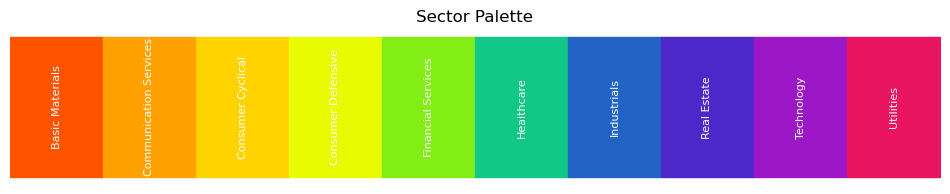

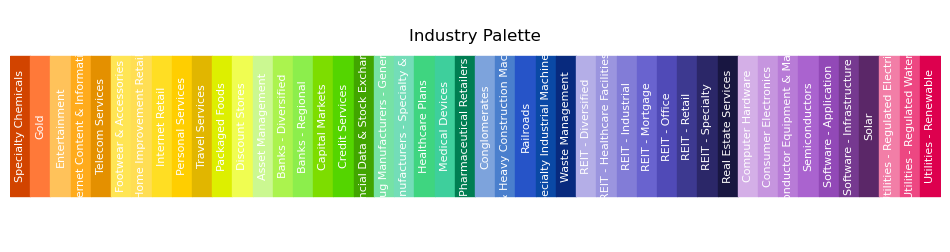

In [22]:


# Define the sector palette with color mappings for each sector
sector_palette = {
    "Basic Materials": "#FF5300",            # Bright orange
    "Communication Services": "#FFA100",     # Orange-yellow
    "Consumer Cyclical": "#FFD300",          # Yellow
    "Consumer Defensive": "#E9FB00",         # Bright yellow-green
    "Financial Services": "#83EE16",         # Light green
    "Healthcare": "#12C888",                 # Teal
    "Industrials": "#2264C6",                # Blue
    "Real Estate": "#4E27CB",                # Purple
    "Technology": "#9C18C6",                 # Magenta
    "Utilities": "#EA1560",                  # Red-pink
}

# Define the industry palette with color mappings for each industry
industry_palette = {
    "Specialty Chemicals": "#D24400",             # Dark orange
    "Gold": "#FF7939",                            # Light orange

    "Entertainment": "#FFC25A",                   # Light yellow-orange
    "Internet Content & Information": "#FFAB1C",  # Bright yellow-orange
    "Telecom Services": "#E49000",                # Orange

    # Consumer Cyclical industries with varying shades of yellow
    "Footwear & Accessories": "#FFE554",          
    "Home Improvement Retail": "#FFDE54",
    "Internet Retail": "#FFDE23",
    "Personal Services": "#FFCE00",
    "Travel Services": "#E1B600",

    # Consumer Defensive industries with shades of green
    "Packaged Foods": "#DDEF00",                  # Light green-yellow
    "Discount Stores": "#F0FD51",                 # Yellow-green

    # Financial Services industries with shades of green
    "Asset Management": "#CBF891",                
    "Banks - Diversified": "#ABF34E",
    "Banks - Regional": "#8CEE4C",
    "Capital Markets": "#7DDD00",
    "Credit Services": "#54D500",
    "Financial Data & Stock Exchanges": "#41A500",# Dark green

    # Healthcare industries with shades of teal and green
    "Drug Manufacturers - General": "#76E2A5",    
    "Drug Manufacturers - Specialty & Generic": "#73DDB8",
    "Healthcare Plans": "#3FD580",
    "Medical Devices": "#3ECF9C",
    "Pharmaceutical Retailers": "#007E52",        # Dark teal

    # Industrials with shades of blue
    "Conglomerates": "#7DA3DC",                   
    "Farm & Heavy Construction Machinery": "#4A7FCD",
    "Railroads": "#2654C8",                       
    "Specialty Industrial Machinery": "#0A49A6",  
    "Waste Management": "#082A7E",                

    # Real Estate with shades of purple
    "REIT - Diversified": "#B4AEE7",
    "REIT - Healthcare Facilities": "#9B95DF",
    "REIT - Industrial": "#827CD7",
    "REIT - Mortgage": "#6963CF",
    "REIT - Office": "#504AB7",
    "REIT - Retail": "#3D3990",
    "REIT - Specialty": "#2B2768",
    "Real Estate Services": "#181641",

    # Technology industries with shades of purple and magenta
    "Computer Hardware": "#D4AFE7",
    "Consumer Electronics": "#C695DF",
    "Semiconductor Equipment & Materials": "#B87BD7",
    "Semiconductors": "#AA63CF",
    "Software - Application": "#9249B7",
    "Software - Infrastructure": "#763990",
    "Solar": "#5B2768",

    # Utilities with shades of pink and red
    "Utilities - Regulated Electric": "#F27EA7",  
    "Utilities - Regulated Water": "#ED4782",     
    "Utilities - Renewable": "#DD004E",           
}

# Function to display the color palette as a horizontal bar with labels
def display_palette(palette, title):
    """
    Displays the color palette as a horizontal bar with each segment representing a key from the palette.
    
    Parameters:
    - palette: A dictionary where keys are sector or industry names and values are hex color codes.
    - title: The title of the plot, indicating whether it's a sector or industry palette.
    """
    plt.figure(figsize=(12, 2))  # Set the figure size
    plt.title(title)  # Set the title of the plot
    for i, (key, color) in enumerate(palette.items()):
        # Draw a color block for each entry in the palette
        plt.fill_between([i, i+1], 0, 1, color=color)
        # Add the label in the center of the block, rotated vertically for readability
        plt.text(i + 0.5, 0.5, key, ha='center', va='center', fontsize=8, color='white', rotation=90)
    plt.xlim(0, len(palette))  # Set the x-axis limits to cover all palette entries
    plt.axis('off')  # Hide the axes for a cleaner look
    plt.show()  # Display the plot

# Display the sector palette as a bar with the title "Sector Palette"
display_palette(sector_palette, "Sector Palette")

# Display the industry palette as a bar with the title "Industry Palette"
display_palette(industry_palette, "Industry Palette")



In [29]:
# Initialize the Dash application
app = Dash(__name__)
app.title = "Stock Price Dashboard"

# Define the main layout of the application
app.layout = html.Div(style={'backgroundColor': '#f7f7f7', 'padding': '20px'}, children=[
    # Main title of the dashboard
    html.H1("Invest Smart", style={'textAlign': 'center', 'color': '#333', 'fontSize': '28px', 'marginBottom': '20px'}),

    # Container for the control panels (filters and options)
    html.Div(style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'center', 'marginBottom': '20px', 'gap': '20px'}, children=[
        # Category selection panel (Company, Sector, Industry)
        html.Div(style={'marginRight': '20px', 'flex': '2', 'minWidth': '200px'}, children=[
            html.Label("Category", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '5px', 'display': 'block'}),
            dcc.RadioItems(
                id='category-radio',
                options=[
                    {'label': 'Company', 'value': 'company'},
                    {'label': 'Sector', 'value': 'sector'},
                    {'label': 'Industry', 'value': 'industry'}
                ],
                value='company',  # Default selection is 'Company'
                style={'marginTop': '10px', 'fontSize': '12px'}
            ),
            dcc.Dropdown(
                id='option-dropdown',
                multi=True,  # Allow multiple selections
                value='All',  # Default value
                style={'width': '100%', 'marginTop': '10px', 'fontSize': '12px'}
            )
        ]),
        # Moving Average selection panel
        html.Div(style={'marginRight': '20px', 'flex': '1'}, children=[
            html.Label("Moving Averages", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '10px', 'display': 'block'}),
            dcc.Dropdown(
                id='ma-dropdown',
                options=[
                    {'label': '50-day MA', 'value': '50MA'},
                    {'label': '100-day MA', 'value': '100MA'},
                    {'label': '200-day MA', 'value': '200MA'}
                ],
                value='50MA',  # Default to 50-day Moving Average
                style={'width': '100%', 'fontSize': '12px', 'marginTop': '5px'}
            )
        ]),
        # Data selection panel for plot (Buy, Sell, Historical, etc.)
        html.Div(style={'marginRight': '20px', 'flex': '2'}, children=[
            html.Label("Data to Plot", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '5px', 'display': 'block'}),
            dcc.Checklist(
                id='data-checklist',
                options=[
                    {'label': 'Historical Price', 'value': 'Close'},
                    {'label': 'Buy Actions', 'value': 'Buy'},
                    {'label': 'Sell Actions', 'value': 'Sell'},
                    {'label': 'Closed Positions', 'value': 'Closed'},
                    {'label': 'New Position', 'value': 'New Position'}
                ],
                value=['Buy', 'Sell'],  # Default to show Buy and Sell actions
                style={'marginTop': '10px', 'fontSize': '12px'}
            )
        ]),
        # Background color selection panel
        html.Div(style={'marginRight': '20px', 'flex': '1'}, children=[
            html.Label("Background Color", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '5px', 'display': 'block'}),
            dcc.RadioItems(
                id='bg-color-radio',
                options=[
                    {'label': 'White', 'value': 'white'},
                    {'label': 'Black', 'value': 'black'}
                ],
                value='black',  # Default to black background
                style={'marginTop': '10px', 'fontSize': '12px'}
            )
        ]),
        # Color scheme and focus options panel
        html.Div(style={'marginRight': '20px', 'flex': '2'}, children=[
            html.Label("Color Scheme", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '5px', 'display': 'block'}),
            dcc.RadioItems(
                id='color-scheme-radio',
                options=[
                    {'label': 'Sector', 'value': 'sector'},
                    {'label': 'Industry', 'value': 'industry'},
                    {'label': 'Profit/Loss Percentage', 'value': 'profit_loss'}
                ],
                value='profit_loss',  # Default to Profit/Loss Percentage
                style={'marginTop': '10px', 'fontSize': '12px'}
            ),
            dcc.Checklist(
                id='focus-checkbox',
                options=[{'label': 'Focus', 'value': 'focus'}],
                value=[],  # Default unchecked
                style={'marginTop': '10px', 'fontSize': '12px'}
            )
        ]),
        # Decision making panel (Past vs Future oriented)
        html.Div(style={'flex': '2'}, children=[
            html.Label("Decision", style={'fontWeight': 'bold', 'fontSize': '14px', 'marginBottom': '5px', 'display': 'block'}),
            dcc.RadioItems(
                id='decision-radio',
                options=[
                    {'label': 'Past Oriented', 'value': 'real_time'},
                    {'label': 'Future Oriented', 'value': 'future_oriented'}
                ],
                value='future_oriented',  # Default to Future Oriented
                style={'marginTop': '10px', 'fontSize': '12px'}
            ),
            dcc.Checklist(
                id='size-mapping-checkbox',
                options=[{'label': 'Scale by Transaction Amount', 'value': 'enable'}],  # Updated label
                value=[],  # Default unchecked (constant size)
                style={'marginTop': '10px', 'fontSize': '12px'}
            )
        ])
    ]),

    # Main content area with the stock graph and additional info
    html.Div(style={'display': 'flex'}, children=[
        # Left side: Stock graph and decision matrix
        html.Div(style={'flex': '3', 'marginRight': '20px'}, children=[
            # Graph to display stock prices and actions
            dcc.Graph(id='stock-graph', style={'height': '60vh'}),
            
            # Buy/Sell decision matrix explaining the labels and color coding
            html.Div(style={'padding': '10px', 'backgroundColor': '#fff', 'border': '1px solid #ddd', 'marginTop': '20px'}, children=[
                html.H4("Buy/Sell Decision Matrix", style={'textAlign': 'center', 'marginBottom': '20px', 'fontSize': '16px'}),
                # Grid layout for decision matrix details
                html.Div(style={'display': 'grid', 'gridTemplateColumns': '1fr 1fr 1fr 1fr', 'gap': '10px'}, children=[
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#e0f7fa'}, children=[
                        html.Div("Good Value-MV Buys", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(Good Decision, buy price is below moving average)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#c8e6c9'}, children=[
                        html.Div("Good Decision-F Buys", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(buy price is below current price)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#ffcdd2'}, children=[
                        html.Div("Good Sell-MV Sells", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(sell price is above moving average)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#d1c4e9'}, children=[
                        html.Div("Good Decision-F Sells", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(sell price is above current price)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#fff9c4'}, children=[
                        html.Div("Expensive Buy-MV Buys", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(Bad Buy, buy price is above moving average)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#ffe0b2'}, children=[
                        html.Div("Bad Decision-F Buys", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(buy price is above the current price)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#ffccbc'}, children=[
                        html.Div("Expensive Sell-MV Sells", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(Bad Sell, sell price is below moving average)", style={'fontSize': '10px'})
                    ]),
                    html.Div(style={'border': '1px solid #ddd', 'padding': '10px', 'backgroundColor': '#f8bbd0'}, children=[
                        html.Div("Bad Decision-F Sells", style={'fontWeight': 'bold', 'fontSize': '12px'}),
                        html.Div("(sell price is below current price)", style={'fontSize': '10px'})
                    ]),
                ])
            ]),
        ]),
        # Right side: Color bar displaying the current color mapping scheme
        html.Div(id='right-column', style={
            'flex': '1', 'textAlign': 'left', 'width': 'fit-content', 'minWidth': '100px', 'maxWidth': '150px', 
            'overflowY': 'auto', 'paddingRight': '10px', 'paddingLeft': '10px'
        }, children=[
            # Placeholder for the dynamically updated color bar
            html.Div(id='color-bar', style={'fontSize': '12px', 'whiteSpace': 'normal'})
        ])
    ])
])

# To run the application, call app.run_server() in your main Python script.


In [30]:

# Initialize Dash application
app = Dash(__name__)

# Define callbacks to update the dropdown options based on category selection
@app.callback(
    Output('option-dropdown', 'options'),
    Input('category-radio', 'value')
)
def update_option_dropdown(category):
    """
    Updates the dropdown options based on the selected category (sector, industry, or company).
    
    Parameters:
    - category: The selected category from the radio buttons ('sector', 'industry', or others).

    Returns:
    - A list of dictionaries where each dictionary represents a dropdown option with a label and value.
    """
    # Filter and sort sectors, excluding 'Unknown', and add an 'All' option
    if category == 'sector':
        sectors = sorted([sector for sector in ticker_info_df['Sector'].unique() if sector != 'Unknown'])
        return [{'label': sector, 'value': sector} for sector in sectors] + [{'label': 'All', 'value': 'All'}]
    
    # Filter and sort industries, excluding 'Unknown', and add an 'All' option
    elif category == 'industry':
        industries = sorted([industry for industry in ticker_info_df['Industry'].unique() if industry != 'Unknown'])
        return [{'label': industry, 'value': industry} for industry in industries] + [{'label': 'All', 'value': 'All'}]
    
    # If category is not sector or industry, list all tickers and add an 'All' option
    else:
        tickers = sorted(ticker_info_df['Ticker'])
        return [{'label': ticker, 'value': ticker} for ticker in tickers] + [{'label': 'All', 'value': 'All'}]

# Define callback to update the color bar based on color scheme and background color selections
@app.callback(
    Output('color-bar', 'children'),
    [Input('color-scheme-radio', 'value'), Input('bg-color-radio', 'value')]
)
def update_color_bar(color_scheme, bg_color):
    """
    Updates the color bar based on the selected color scheme (industry, sector, or profit/loss)
    and background color.

    Parameters:
    - color_scheme: Selected color scheme ('industry', 'sector', 'profit_loss').
    - bg_color: Selected background color ('white' or other).

    Returns:
    - A styled Div containing color blocks representing different categories.
    """
    # Define the style for the container of the color bar
    container_style = {
        'display': 'flex', 
        'flexDirection': 'column', 
        'alignItems': 'flex-start', 
        'width': '100%', 
        'padding': '10px', 
        'overflowY': 'auto'
    }

    color_bar = []

    # Generate a color bar by mapping industries within each sector
    if color_scheme == 'industry':
        # Create a dictionary mapping sectors to industries, removing 'Unknown' values
        sector_industry_mapping = (
            ticker_info_df[ticker_info_df['Sector'] != 'Unknown']
            .groupby('Sector')['Industry']
            .apply(lambda x: sorted(set(x) - {'Unknown'}))
            .to_dict()
        )

        # Iterate through sectors and their industries to create color blocks
        for sector, industries in sector_industry_mapping.items():
            sector_color = sector_palette.get(sector, '#808080')  # Default to grey if no color defined
            industry_blocks = []

            # Create a block for each industry under the sector
            for industry in industries:
                industry_color = industry_palette.get(industry, '#808080')  # Default to grey if no color defined
                industry_blocks.append(html.Div(style={
                    'backgroundColor': industry_color,
                    'padding': '5px 10px',
                    'marginBottom': '2px',
                    'borderRadius': '5px',
                    'color': 'white',
                    'fontSize': '10px',
                    'textAlign': 'left',
                    'width': '100%',
                    'whiteSpace': 'normal',
                    'overflow': 'hidden',
                    'textOverflow': 'ellipsis'
                }, children=industry))

            # Add a sector block with associated industries displayed
            color_bar.append(html.Div(style={'display': 'flex', 'width': '100%', 'marginBottom': '10px'}, children=[
                # Sector displayed vertically
                html.Div(style={
                    'backgroundColor': sector_color,
                    'padding': '5px',
                    'borderRadius': '5px',
                    'color': 'white',
                    'fontSize': '12px',
                    'textAlign': 'center',
                    'width': '35px',
                    'whiteSpace': 'nowrap',
                    'overflow': 'hidden',
                    'textOverflow': 'ellipsis',
                    'writingMode': 'vertical-rl',
                    'transform': 'rotate(180deg)',
                    'lineHeight': '1.5',
                }, children=sector),
                # Industries under the sector
                html.Div(style={
                    'display': 'flex', 
                    'flexDirection': 'column', 
                    'width': 'calc(100% - 40px)', 
                    'paddingLeft': '10px'
                }, children=industry_blocks)
            ]))

    # Generate a color bar with sectors listed vertically
    elif color_scheme == 'sector':
        sectors = sorted(ticker_info_df[ticker_info_df['Sector'] != 'Unknown']['Sector'].unique())
        for sector in sectors:
            sector_color = sector_palette.get(sector, '#808080')  # Default to grey if no color defined
            color_bar.append(html.Div(style={
                'backgroundColor': sector_color,
                'padding': '5px 10px',
                'marginBottom': '5px',
                'borderRadius': '5px',
                'color': 'white',
                'fontSize': '12px',
                'textAlign': 'left',
                'width': '100%',
                'whiteSpace': 'nowrap'
            }, children=sector))

    # Generate a profit/loss color bar with predefined ranges
    elif color_scheme == 'profit_loss':
        labels = ['<-30%', '-20%', '-10%', '0%', '+10%', '+20%', '>+30%']
        palette = ['#8B0000', '#B22222', '#FF4500', '#FFD700', '#ADFF2F', '#7CFC00', '#006400'] if bg_color == 'white' else ['#FF6347', '#FF7F50', '#FFA07A', '#FFD700', '#ADFF2F', '#7FFF00', '#32CD32']
        
        # Add each label with corresponding color
        for i, label in enumerate(labels):
            color_bar.append(html.Div(style={
                'backgroundColor': palette[i],
                'padding': '5px 10px',
                'marginBottom': '5px',
                'borderRadius': '5px',
                'color': 'white',
                'fontSize': '12px',
                'textAlign': 'left',
                'width': '100%',
                'whiteSpace': 'nowrap'
            }, children=label))

    # Return the styled color bar as a Div component
    return html.Div(style=container_style, children=color_bar)

# Define callback to update the stock graph based on multiple input parameters
@app.callback(
    Output('stock-graph', 'figure'),
    [Input('option-dropdown', 'value'),
     Input('ma-dropdown', 'value'),
     Input('bg-color-radio', 'value'),
     Input('color-scheme-radio', 'value'),
     Input('data-checklist', 'value'),
     Input('category-radio', 'value'),
     Input('decision-radio', 'value'),
     Input('focus-checkbox', 'value'),
     Input('size-mapping-checkbox', 'value')]
)
def update_graph(selected_option, selected_ma, bg_color, color_scheme, selected_data, category, decision, focus, size_mapping):
    """
    Updates the stock graph based on selected options, moving averages, color schemes, and data filters.
    
    Parameters:
    - selected_option: Options selected from the dropdown, representing sectors, industries, or tickers.
    - selected_ma: The selected moving average indicator.
    - bg_color: The chosen background color ('white' or other).
    - color_scheme: The chosen color scheme ('sector', 'industry', or 'profit_loss').
    - selected_data: List of selected data types to display (e.g., 'Close', 'Buy', 'Sell').
    - category: The selected category ('sector', 'industry', or 'company').
    - decision: A decision-making input to influence the graph's appearance.
    - focus: A focus option that highlights selected data in the graph.
    - size_mapping: A size mapping option that scales marker sizes based on data.

    Returns:
    - A Plotly figure representing the stock data with appropriate customizations.
    """
    # Initialize the figure
    fig = go.Figure()

    # Set background and grid colors based on the selected background color
    if bg_color == 'white':
        plot_bgcolor = '#f7fbff'
        gridcolor = '#d1e2f3'
    else:
        plot_bgcolor = '#1e1e1e'
        gridcolor = '#333333'

    # Set up color mapping based on the selected color scheme
    if color_scheme == 'sector':
        unique_labels = ticker_info_df[ticker_info_df['Sector'] != 'Unknown']['Sector'].unique()
        palette = sector_palette
    elif color_scheme == 'industry':
        unique_labels = ticker_info_df[ticker_info_df['Industry'] != 'Unknown']['Industry'].unique()
        palette = industry_palette
    elif color_scheme == 'profit_loss':
        unique_labels = ['<-30%', '-20%', '-10%', '0%', '+10%', '+20%', '>+30%']
        palette = ['#8B0000', '#B22222', '#FF4500', '#FFD700', '#ADFF2F', '#7CFC00', '#006400'] if bg_color == 'white' else ['#FF6347', '#FF7F50', '#FFA07A', '#FFD700', '#ADFF2F', '#7FFF00', '#32CD32']
        profit_loss_mapping = {}
        
        # Map tickers to their respective colors based on profit/loss percentages
        for _, row in profit_loss_df.iterrows():
            ticker = row['Ticker']
            percentage = row['Profit/Loss Percentage']

            # Handle NaN values by setting a default value or skipping
            if pd.isna(percentage):
                percentage = 0  # Default to 0 or choose another appropriate value

            # Safely map percentage to color range
            try:
                color = palette[
                    min(max(int((percentage + 30) // 10), 0), len(palette) - 1)  # Map percentage to palette range
                ]
            except ValueError:
                color = '#808080'  # Fallback color in case of unexpected values

            profit_loss_mapping[ticker] = color
    else:
        unique_labels = []

    # Create a color mapping for labels using the selected palette
    color_mapping = {label: palette[i % len(palette)] if isinstance(palette, list) else palette.get(label, '#1f77b4') for i, label in enumerate(unique_labels)}

    # Define function to determine the color of each line or marker
    def get_color(label, ticker):
        """
        Determines the color for each ticker based on the selected color scheme.
        
        Parameters:
        - label: The label used for color mapping (sector, industry, or custom).
        - ticker: The ticker symbol for the company.

        Returns:
        - A string representing the color in hex format.
        """
        # Get color from the profit/loss mapping if the scheme is 'profit_loss'
        if color_scheme == 'profit_loss':
            color = profit_loss_mapping.get(ticker, '#808080')
        else:
            color = color_mapping.get(label, '#1f77b4')

        # Apply focus logic: show selected items in color, others in grey
        if 'focus' in focus and 'All' not in selected_option:
            is_selected = (
                (category == 'sector' and ticker_info_df[ticker_info_df['Ticker'] == ticker]['Sector'].values[0] in selected_option) or
                (category == 'industry' and ticker_info_df[ticker_info_df['Ticker'] == ticker]['Industry'].values[0] in selected_option) or
                (category == 'company' and ticker in selected_option)
            )
            if not is_selected:
                return '#D3D3D3'  # Light grey for non-selected items

        return color

    # Define function to determine line width and opacity based on focus
    def get_line_properties(ticker):
        """
        Adjusts line properties based on whether the ticker is focused or not.
        
        Parameters:
        - ticker: The ticker symbol for the company.

        Returns:
        - A tuple of line width and opacity.
        """
        # Check if focus is selected and all items are selected
        if 'focus' in focus and 'All' not in selected_option:
            is_selected = (
                (category == 'sector' and ticker_info_df[ticker_info_df['Ticker'] == ticker]['Sector'].values[0] in selected_option) or
                (category == 'industry' and ticker_info_df[ticker_info_df['Ticker'] == ticker]['Industry'].values[0] in selected_option) or
                (category == 'company' and ticker in selected_option)
            )
            if is_selected:
                return 2.0, 1.0  # Thicker line and less opaque
        return 1.0, 0.7  # Default line width and opacity

    # Track items already shown in the legend
    legend_items = set()

    # Helper function to add traces with proper legends
    def add_trace_with_legend(x, y, name, color, symbol, ticker, actual_marker_size):
        """
        Adds a scatter trace to the graph with appropriate legend management.

        Parameters:
        - x: List of x-axis values (e.g., dates).
        - y: List of y-axis values (e.g., prices).
        - name: The name to display in the legend.
        - color: The color of the markers.
        - symbol: The symbol shape for the markers.
        - ticker: The ticker symbol associated with the trace.
        - actual_marker_size: The actual size of the marker.

        Returns:
        - A Plotly Scatter trace.
        """
        # Define fixed legend size
        legend_marker_size = 10
        # Show legend only once
        show_legend = name not in legend_items
        legend_items.add(name)

        hovertemplate = (
            f"<b>{ticker}</b><br>Date: {x[0]:%b %Y}<br>Price: {y[0]:.2f}"
        )

        return go.Scatter(
            x=x, y=y,
            mode='markers',
            name=name,  
            marker=dict(
                color=color, 
                symbol=symbol, 
                size=legend_marker_size if show_legend else actual_marker_size
            ),  
            showlegend=show_legend,
            hovertemplate=hovertemplate
        )

    # Identify the companies to plot based on the selected category and options
    if 'All' in selected_option:
        companies_to_plot = ticker_info_df['Ticker'].unique()
    else:
        if category == 'sector':
            companies_to_plot = ticker_info_df[ticker_info_df['Sector'].isin(selected_option)]['Ticker'].unique()
        elif category == 'industry':
            companies_to_plot = ticker_info_df[ticker_info_df['Industry'].isin(selected_option)]['Ticker'].unique()
        else:
            companies_to_plot = selected_option

    # Define marker size scaling parameters
    min_marker_size = 9
    max_marker_size = 25
    transaction_min = data_sorted['Total'].min()
    transaction_max = data_sorted['Total'].max()

    # Plot non-selected companies, sectors, or industries in grey when focus is on and not "All"
    if 'focus' in focus and 'All' not in selected_option:
        for ticker in ticker_info_df['Ticker'].unique():
            if ticker in historical_data and not historical_data[ticker].empty:
                label = (
                    ticker_info_df[ticker_info_df['Ticker'] == ticker]['Sector'].values[0]
                    if category == 'sector' else
                    ticker_info_df[ticker_info_df['Ticker'] == ticker]['Industry'].values[0]
                    if category == 'industry' else ticker
                )
                if label not in selected_option:
                    if bg_color == 'white':
                        line_color = '#D3D3D3' # Light grey
                    else:
                        line_color = '#5C5C5C'  # Dark grey

                    # Add the closing price and moving averages for the ticker
                    company_data = historical_data[ticker].reset_index()

                    # Adhere to plot filters for new positions
                    if 'New Position' in selected_data:
                        if not metadata_df.loc[metadata_df['Ticker Symbol'] == ticker].empty:
                            first_buy_date = metadata_df.loc[metadata_df['Ticker Symbol'] == ticker, 'Date of First (Oldest)\n Purchase'].values[0]
                            start_date = first_buy_date - pd.Timedelta(days=10)
                            company_data = company_data[company_data['Date'] >= start_date]

                    # Determine the cut-off date for closed positions
                    cut_off_date = None
                    if 'Closed' in selected_data:
                        if not metadata_df.loc[metadata_df['Ticker Symbol'] == ticker].empty:
                            net_shares = metadata_df.loc[metadata_df['Ticker Symbol'] == ticker, 'Net Total Number of Shares (=Purchased - Sold)\n'].values[0]
                            if net_shares == 0:
                                sell_data = data_sorted[(data_sorted['Ticker'] == ticker) & (data_sorted['Action'].str.lower() == 'market sell')]
                                if not sell_data.empty:
                                    last_sell_date = sell_data.iloc[-1]['Date']
                                    cut_off_date = last_sell_date + pd.Timedelta(days=10)  # Add 10 days after the last sell date

                    # Filter data up to the cut-off date if exists
                    if cut_off_date:
                        company_data = company_data[company_data['Date'] <= cut_off_date]

                    # Add the closing price and moving averages adhering to selected filters
                    if 'Close' in selected_data:
                        fig.add_trace(go.Scatter(
                            x=np.array(company_data['Date']), y=company_data['Close'],
                            mode='lines', name=f'{ticker} (Close)',
                            line=dict(color=line_color, width=1.0), opacity=0.7, showlegend=False
                        ))

                    for ma in [selected_ma]:
                        if ma in company_data.columns:
                            fig.add_trace(go.Scatter(
                                x=np.array(company_data['Date']), y=company_data[ma],
                                mode='lines', name=f'{ticker} ({ma})',
                                line=dict(color=line_color, dash='solid', width=1.0), opacity=0.7, showlegend=False
                            ))

    # Plot selected companies, sectors, or industries last in their respective colors
    for ticker in companies_to_plot:
        if ticker in historical_data and not historical_data[ticker].empty:
            company_data = historical_data[ticker].reset_index()
            # Adjust label to reflect the current color scheme
            if color_scheme == 'sector':
                label = ticker_info_df[ticker_info_df['Ticker'] == ticker]['Sector'].values[0]
            elif color_scheme == 'industry':
                label = ticker_info_df[ticker_info_df['Ticker'] == ticker]['Industry'].values[0]
            else:
                label = ticker  # Profit/Loss scheme by ticker
            line_color = get_color(label, ticker)
            line_width, line_opacity = get_line_properties(ticker)  # Get line width and opacity based on focus

            # Plot buy and sell actions first (to appear first in the legend)
            company_transactions = data_sorted[data_sorted['Ticker'] == ticker]
            buy_data = company_transactions[company_transactions['Action'].str.lower() == 'market buy']
            sell_data = company_transactions[company_transactions['Action'].str.lower() == 'market sell']

            # Determine marker size logic based on user option
            if 'enable' in size_mapping:
                # Map size to transaction total
                def calculate_marker_size(transaction_size):
                    return (transaction_size - transaction_min) / (transaction_max - transaction_min) * (max_marker_size - min_marker_size) + min_marker_size
            else:
                # Use a constant size
                def calculate_marker_size(transaction_size):
                    return 9  # Constant size

            # Plot buy actions with appropriate markers
            if 'Buy' in selected_data:
                for _, row in buy_data.iterrows():
                    action_date = row['Date']
                    action_price = row['Price / share adjusted for split(s)']
                    transaction_size = row['Total']
                    color = evaluate_buy_sell(ticker, action_date, action_price, 'buy', decision)
                    label = 'Good Buy' if color == 'green' else 'Bad Buy'
                    marker_size = calculate_marker_size(transaction_size)
                    fig.add_trace(add_trace_with_legend(
                        x=[action_date], y=[action_price],
                        name=label, color=color, symbol='circle', ticker=ticker, actual_marker_size=marker_size
                    ))

            # Plot sell actions with appropriate markers
            if 'Sell' in selected_data:
                for _, row in sell_data.iterrows():
                    action_date = row['Date']
                    action_price = row['Price / share adjusted for split(s)']
                    transaction_size = row['Total']
                    color = evaluate_buy_sell(ticker, action_date, action_price, 'sell', decision)
                    label = 'Good Sell' if color == 'green' else 'Bad Sell'
                    marker_size = calculate_marker_size(transaction_size)
                    fig.add_trace(add_trace_with_legend(
                        x=[action_date], y=[action_price],
                        name=label, color=color, symbol='triangle-up', ticker=ticker, actual_marker_size=marker_size
                    ))

            # Handle the New Position option to start the line from 10 days before the first buy
            if 'New Position' in selected_data:
                if not metadata_df.loc[metadata_df['Ticker Symbol'] == ticker].empty:
                    first_buy_date = metadata_df.loc[metadata_df['Ticker Symbol'] == ticker, 'Date of First (Oldest)\n Purchase'].values[0]
                    start_date = first_buy_date - pd.Timedelta(days=10)
                    company_data = company_data[company_data['Date'] >= start_date]

            # Determine the cut-off date for closed positions
            cut_off_date = None
            if 'Closed' in selected_data:
                if not metadata_df.loc[metadata_df['Ticker Symbol'] == ticker].empty:
                    net_shares = metadata_df.loc[metadata_df['Ticker Symbol'] == ticker, 'Net Total Number of Shares (=Purchased - Sold)\n'].values[0]
                    if net_shares == 0:
                        sell_data = data_sorted[(data_sorted['Ticker'] == ticker) & (data_sorted['Action'].str.lower() == 'market sell')]
                        if not sell_data.empty:
                            last_sell_date = sell_data.iloc[-1]['Date']
                            cut_off_date = last_sell_date + pd.Timedelta(days=10)  # Add 10 days after the last sell date

            # Filter data up to the cut-off date if exists
            if cut_off_date:
                company_data = company_data[company_data['Date'] <= cut_off_date]

            # Add the closing price and moving averages after buy/sell actions
            if 'Close' in selected_data:
                fig.add_trace(go.Scatter(
                    x=np.array(company_data['Date']), y=company_data['Close'],
                    mode='lines', name=f'{ticker} (Close)',
                    line=dict(color=line_color, width=line_width), opacity=line_opacity
                ))

            for ma in [selected_ma]:
                if ma in company_data.columns:
                    fig.add_trace(go.Scatter(
                        x=np.array(company_data['Date']), y=company_data[ma],
                        mode='lines', name=f'{ticker} ({ma})',
                        line=dict(color=line_color, dash='solid', width=line_width), opacity=line_opacity
                    ))

    # Update figure layout with titles, grid settings, and color schemes
    fig.update_layout(
        title='Daily Stock Price',
        xaxis_title='Date',
        yaxis_title='Stock Price',
        legend_title='Legend',
        hovermode='closest',  # Show only the closest point to the cursor
        template='plotly_white' if bg_color == 'white' else 'plotly_dark',
        plot_bgcolor=plot_bgcolor,
        paper_bgcolor=plot_bgcolor,
        xaxis=dict(gridcolor=gridcolor),
        yaxis=dict(gridcolor=gridcolor)
    )

    return fig

# Define callback to update the moving average selection based on decision
@app.callback(
    Output('ma-dropdown', 'value'),
    Input('decision-radio', 'value'),
    State('ma-dropdown', 'value')
)
def update_ma_based_on_decision(decision, current_ma):
    """
    Updates the moving average selection based on the decision option selected.
    
    Parameters:
    - decision: Selected decision option ('real_time' or others).
    - current_ma: The currently selected moving average.

    Returns:
    - The updated moving average value.
    """
    # Change to 200MA if 'real_time' decision is selected
    if decision == 'real_time':
        return '200MA'
    return current_ma  # Keep the current selection otherwise

# Main entry point to run the Dash application
if __name__ == '__main__':
    app.run_server(debug=False, port='8066')
